In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import os

In [2]:
import keras
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Activation
from keras.layers import Dropout, Input, BatchNormalization
from keras.losses import mse
from keras.optimizers import Adadelta
from keras.models import Model

from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k
 
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))
###################################

## seed
np.random.seed(1)
tf.set_random_seed(2)

In [4]:
def Conv3D_model(input_shape):
    input_layer = Input(input_shape)

    conv_layer1 = Conv3D(filters=1, kernel_size=(3, 3, 3))(input_layer)
    conv_layer1 = BatchNormalization()(conv_layer1)
    conv_layer1 = Activation('relu')(conv_layer1)
    pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer1)

    conv_layer2 = Conv3D(filters=1, kernel_size=(3, 3, 3))(pooling_layer1)
    conv_layer2 = BatchNormalization()(conv_layer2)
    conv_layer2 = Activation('relu')(conv_layer2)
    pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

    conv_layer3 = Conv3D(filters=16, kernel_size=(3, 3, 3))(pooling_layer2)
    conv_layer3 = BatchNormalization()(conv_layer3)
    conv_layer3 = Activation('relu')(conv_layer3)
    pooling_layer3 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer3)

    conv_layer4 = Conv3D(filters=32, kernel_size=(3, 3, 3))(pooling_layer3)
    conv_layer4 = BatchNormalization()(conv_layer4)
    conv_layer4 = Activation('relu')(conv_layer4)
    pooling_layer4 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

    flatten_layer = Flatten()(pooling_layer3)

    dense_layer1 = Dense(units=1024, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.6)(dense_layer1)
    dense_layer2 = Dense(units=256, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.6)(dense_layer2)
    output_layer = Dense(units=1, activation='linear')(dense_layer2)

    return Model(inputs=input_layer, outputs=output_layer)

In [5]:
class DataGen:
    
    def __init__(self, csv,  directory):
        df = pd.read_csv(csv)
        self.dir = directory
        self.filename = np.array(df['file'])
        self.age      = np.array(df['age'])
        self.gender   = np.array(df['gender'])=='f'
        
        one_brain = np.array(nib.load( os.path.join(self.dir, self.filename[0]) ).get_data())
        self.shape = one_brain.shape
        self.dtype = one_brain.dtype
        self.total_samples = len(self.filename)
        
        self.next_index = 0
        self.init()
        
        
    def init(self):
        rand_indicies = np.random.permutation(np.arange(len(self.filename)))
        self.filename = self.filename[rand_indicies]
        self.age = self.age[rand_indicies]
        self.gender = self.gender[rand_indicies]
        self.next_index = 0
        
    def samples_left(self):
        return self.total_samples - self.next_index
        
    def getBatch(self, n_samples):
        n_samples_left = self.samples_left()
        assert n_samples_left>0, "No samples left, call dataGen.init()"
        
        n_samples = n_samples if n_samples_left>n_samples else n_samples_left
        data = np.empty((n_samples,)+self.shape+(1,), self.dtype)
        label = np.empty(n_samples, self.dtype)
        # should spawn a thread to load data
        for i in range(n_samples):
            data[i,:,:,:,0] = np.array(nib.load(os.path.join(self.dir, self.filename[self.next_index])).get_data())
            label[i] = self.age[self.next_index]
            self.next_index = self.next_index+1
        
        return data, label
            

In [6]:
# split data
'''
df = pd.read_csv('IXI_labels.csv')
df_train = df.iloc[:450, :]
df_val = df.iloc[450:500, :]
df_test = df.iloc[500:, :]

print(len(df_train), len(df_val), len(df_test))
df_train.to_csv("IXI_train.csv", sep=',')
df_val.to_csv("IXI_val.csv", sep=',')
df_test.to_csv("IXI_test.csv", sep=',')
'''

'\ndf = pd.read_csv(\'IXI_labels.csv\')\ndf_train = df.iloc[:450, :]\ndf_val = df.iloc[450:500, :]\ndf_test = df.iloc[500:, :]\n\nprint(len(df_train), len(df_val), len(df_test))\ndf_train.to_csv("IXI_train.csv", sep=\',\')\ndf_val.to_csv("IXI_val.csv", sep=\',\')\ndf_test.to_csv("IXI_test.csv", sep=\',\')\n'

In [7]:
dg = DataGen('IXI_train.csv', './IXI_brain')
dg_val = DataGen('IXI_train.csv', './IXI_brain')

In [8]:
dg.samples_left()

450

In [9]:
X,y = dg.getBatch(1)

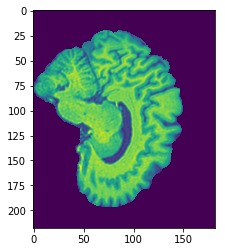

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(np.take(X[0,:,:,:,0], 100, 0))
plt.show()

In [ ]:
model = Conv3D_model(dg.shape+(1,))
batch_size = 1
epochs = 10
model.compile(loss=mse, optimizer=Adadelta(lr=0.01), metrics=['mae'])

v_mse_hist = []
v_loss_hist = []
t_mse_hist = []
t_loss_hist = []

from IPython.display import clear_output

In [ ]:
for i in range(epochs):
    dg.init()
    print("epoch", i)
    while(dg.samples_left()>0):
        X,y = dg.getBatch(batch_size)
        model.fit(x=X, y=y, verbose=0)
    dg.getBatch(batch_size)
    dg.init()
    X,y = dg.getBatch(50)
    loss, mse_val = evaluate(x=X, y=y, batch_size=1, verbose=1)
    t_loss_hist.append(loss)
    plt.plot(t_loss_hist)

In [ ]:
#y_pred = model.predict(X, batch_size=1)